# COVID-19 Data Engineering and Analysis Project

This project focuses on analyzing COVID-19 data to extract meaningful insights using ETL processes and data engineering techniques.

## Introduction
This project provides detailed insights into the pandemic period, leveraging comprehensive data analysis techniques to highlight significant trends and patterns in COVID-19 cases and deaths worldwide.

### Dependencies
Import all relevant dependencies for the project,

In [1]:
# Import Dependencies
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from datetime import datetime
# Import New Librarie not covered in class
import pyarrow as pa
import pyarrow.csv as pv_csv

### Extract COVID-19 Data
Reading in the datasets for countries and COVID-19 cases.

In [2]:
# Read and Load the CSV file into a DataFrame
countries_dataset_path = "Resources/countries.csv"
countries_dataset = pd.read_csv(countries_dataset_path)

# Display the first few rows to verify
countries_dataset.head()

,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla


In [3]:
# Read and Load the CSV file into a DataFrame
covid_cases_dataset_path = "Resources/WHO COVID-19 cases.csv"
covid_cases_dataset = pd.read_csv(covid_cases_dataset_path)

# Display the first few rows to verify
covid_cases_dataset.head()

,Date_reported,Country_code,Country,Continent,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-05,AF,Afghanistan,Asia,EMRO,NaN,0,NaN,0
1,2020-01-12,AF,Afghanistan,Asia,EMRO,NaN,0,NaN,0
2,2020-01-19,AF,Afghanistan,Asia,EMRO,NaN,0,NaN,0
3,2020-01-26,AF,Afghanistan,Asia,EMRO,NaN,0,NaN,0
4,2020-02-02,AF,Afghanistan,Asia,EMRO,NaN,0,NaN,0


### User-driven Interaction
Filter data based on date, country, or WHO region.

In [4]:
def filter_csv_data(df):
    print("Select a filter:")
    print("1. Filter by Date")
    print("2. Filter by Country")
    print("3. Filter by WHO_region")
    print("4. No filter (Load all data)")

    filter_option = input("Enter the number corresponding to your filter choice: ")

    df = covid_cases_dataset

    # Apply filters based on user selection
    if filter_option == '1':
        start_date = input("Enter start date (YYYY-MM-DD): ")
        end_date = input("Enter end date (YYYY-MM-DD): ")
        df['Date_reported'] = pd.to_datetime(df['Date_reported'])
        df = df[(df['Date_reported'] >= start_date) & (df['Date_reported'] <= end_date)]
    elif filter_option == '2':
        country = input("Enter country to filter by: ")
        df = df[df['Country'] == country]
    elif filter_option == '3':
        who = input("Enter your desired WHO Region: ").upper()
        df = df[df['WHO_region'] == who]
    elif filter_option == '4':
        print("No filter applied.")
    else:
        print("Invalid option.")
    
    # Perform further ETL processes on filtered data
    return df

filtered_data = filter_csv_data(covid_cases_dataset)
filtered_data.head()

Select a filter:
1. Filter by Date
2. Filter by Country
3. Filter by WHO_region
4. No filter (Load all data)
No filter applied.


,Date_reported,Country_code,Country,Continent,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-05,AF,Afghanistan,Asia,EMRO,NaN,0,NaN,0
1,2020-01-12,AF,Afghanistan,Asia,EMRO,NaN,0,NaN,0
2,2020-01-19,AF,Afghanistan,Asia,EMRO,NaN,0,NaN,0
3,2020-01-26,AF,Afghanistan,Asia,EMRO,NaN,0,NaN,0
4,2020-02-02,AF,Afghanistan,Asia,EMRO,NaN,0,NaN,0


### Data Transformation and Cleaning
Renaming columns, merging datasets, handling missing and duplicate data, and adjusting data types.

In [5]:
# Rename columns for merging
countries_dataset = countries_dataset.rename(columns={'country': 'Country Code', 'name': 'Country'})
covid_cases_dataset = covid_cases_dataset.rename(columns={
    'Date_reported': 'Date',
    'Country_code': 'Country Code',
    'Country': 'Country',
    'WHO_region': 'WHO Region',
    'New_cases': 'New Cases',
    'Cumulative_cases': 'Cumulative Cases',
    'New_deaths': 'New Deaths',
    'Cumulative_deaths': 'Cumulative Deaths'
})

# Merge datasets to create the COVID-19 Dataset
complete_dataset_raw = pd.merge(covid_cases_dataset, countries_dataset, on="Country Code", how='outer')
complete_dataset_raw = complete_dataset_raw.drop(columns=["Country_y"]).rename(columns={
    "Country_x": "Country",
    "latitude": "Latitude",
    "longitude": "Longitude"
})
complete_dataset_raw['id'] = range(1, len(complete_dataset_raw) + 1)
columns = ['id'] + [col for col in complete_dataset_raw.columns if col != 'id']
complete_dataset_raw = complete_dataset_raw[columns]
complete_dataset_raw = complete_dataset_raw.dropna().drop_duplicates(subset=['Date', 'Country'])
complete_dataset_raw['Date'] = pd.to_datetime(complete_dataset_raw['Date'])
LngLatdataset = complete_dataset_raw.copy()

# Create 'Case ID' before dropping columns
complete_dataset_raw['Case ID'] = complete_dataset_raw['Country Code'] + complete_dataset_raw['id'].astype(str)

# Add 'Coordinates' column
complete_dataset_raw['Coordinates'] = complete_dataset_raw.apply(lambda row: f"({row['Latitude']}, {row['Longitude']})", axis=1)

# Drop unnecessary columns
complete_dataset_cleaned = complete_dataset_raw.drop(columns=['Longitude', 'Latitude'])

# Ensure all columns have spaces instead of underscores
complete_dataset_cleaned.columns = complete_dataset_cleaned.columns.str.replace('_', ' ')

# Reorder the columns to match the desired order
desired_order = ['id', 'Date', 'Country Code', 'Country', 'Continent', 'WHO Region', 'New Cases', 'Cumulative Cases', 'New Deaths', 'Cumulative Deaths', 'Coordinates', 'Case ID']
complete_dataset_cleaned = complete_dataset_cleaned[desired_order]

# Check results
complete_dataset_cleaned.head()

,id,Date,Country Code,Country,Continent,WHO Region,New Cases,Cumulative Cases,New Deaths,Cumulative Deaths,Coordinates,Case ID
12,13,2020-03-29,AF,Afghanistan,Asia,EMRO,67.0,91.0,2.0,2.0,"(33.93911, 67.709953)",AF13
13,14,2020-04-05,AF,Afghanistan,Asia,EMRO,183.0,274.0,3.0,5.0,"(33.93911, 67.709953)",AF14
14,15,2020-04-12,AF,Afghanistan,Asia,EMRO,247.0,521.0,10.0,15.0,"(33.93911, 67.709953)",AF15
15,16,2020-04-19,AF,Afghanistan,Asia,EMRO,387.0,908.0,15.0,30.0,"(33.93911, 67.709953)",AF16
16,17,2020-04-26,AF,Afghanistan,Asia,EMRO,422.0,1330.0,13.0,43.0,"(33.93911, 67.709953)",AF17


### Countries DataFrame
Creating and exporting a DataFrame for country codes and names.

In [6]:
# Create and Save the Countries DataFrame. Remove duplicates based on 'Country Code'
Countries_df = complete_dataset_cleaned[['Country Code', 'Country']].drop_duplicates(subset=['Country Code']).reset_index(drop=True)
Countries_df.to_csv('COVID-19-ETL-Outputs/Countries.csv', index=False)
print("Countries DataFrame saved as 'Countries.csv'")
Countries_df.head()

Countries DataFrame saved as 'Countries.csv'


,Country Code,Country
0,AF,Afghanistan
1,AL,Albania
2,DZ,Algeria
3,AS,American Samoa
4,AD,Andorra


### Coordinates DataFrame
Creating and exporting a DataFrame for country coordinates.

In [7]:
# Filter out non-numeric values from Latitude and Longitude
LngLatdataset = complete_dataset_raw[
    complete_dataset_raw['Latitude'].apply(lambda x: pd.to_numeric(x, errors='coerce')).notnull() &
    complete_dataset_raw['Longitude'].apply(lambda x: pd.to_numeric(x, errors='coerce')).notnull()
]

# Convert Latitude and Longitude to numeric
LngLatdataset['Latitude'] = pd.to_numeric(LngLatdataset['Latitude'])
LngLatdataset['Longitude'] = pd.to_numeric(LngLatdataset['Longitude'])

# Create Coordinates DataFrame
Coordinates_df = LngLatdataset[['Country Code', 'Latitude', 'Longitude', 'Coordinates']].drop_duplicates().reset_index(drop=True)

# Save the Coordinates DataFrame as CSV
Coordinates_csv_path = 'COVID-19-ETL-Outputs/Coordinates.csv'
Coordinates_df.to_csv(Coordinates_csv_path, index=False)

# Convert the Coordinates_df DataFrame to a PyArrow Table
coordinates_df_table = pa.Table.from_pandas(Coordinates_df)
with open('COVID-19-ETL-Outputs/Coordinates.csv', 'wb') as f:
    pv_csv.write_csv(coordinates_df_table, f)

print("Coordinates DataFrame saved as 'Coordinates.csv'")

Coordinates DataFrame saved as 'Coordinates.csv'


### COVID-19 Dataset
Creating and Saving the COVID-19_Dataset

In [8]:
# Save the cleaned and renamed COVID-19 Dataset
complete_dataset_cleaned.to_csv('COVID-19-ETL-Outputs/COVID-19_Dataset.csv', index=False)
print("COVID-19 Dataset saved as 'COVID-19_Dataset.csv'")
complete_dataset_cleaned.head()

COVID-19 Dataset saved as 'COVID-19_Dataset.csv'


,id,Date,Country Code,Country,Continent,WHO Region,New Cases,Cumulative Cases,New Deaths,Cumulative Deaths,Coordinates,Case ID
12,13,2020-03-29,AF,Afghanistan,Asia,EMRO,67.0,91.0,2.0,2.0,"(33.93911, 67.709953)",AF13
13,14,2020-04-05,AF,Afghanistan,Asia,EMRO,183.0,274.0,3.0,5.0,"(33.93911, 67.709953)",AF14
14,15,2020-04-12,AF,Afghanistan,Asia,EMRO,247.0,521.0,10.0,15.0,"(33.93911, 67.709953)",AF15
15,16,2020-04-19,AF,Afghanistan,Asia,EMRO,387.0,908.0,15.0,30.0,"(33.93911, 67.709953)",AF16
16,17,2020-04-26,AF,Afghanistan,Asia,EMRO,422.0,1330.0,13.0,43.0,"(33.93911, 67.709953)",AF17


### Patient Database
Creating and exporting a DataFrame for all COVID-19 cases and deaths.

In [9]:
# Create and Save the Patient Database DataFrame
Patient_Database = pd.DataFrame({
    'Case ID': complete_dataset_cleaned['Case ID'].astype(str),
    'Date': complete_dataset_cleaned['Date'],
    'Country Code': complete_dataset_cleaned['Country Code'],
    'New Cases': complete_dataset_cleaned['New Cases'],
    'Cumulative Cases': complete_dataset_cleaned['Cumulative Cases'],
    'New Deaths': complete_dataset_cleaned['New Deaths'],
    'Cumulative Deaths': complete_dataset_cleaned['Cumulative Deaths']
})
Patient_Database = Patient_Database.dropna(how='any')
Patient_Database.to_csv('COVID-19-ETL-Outputs/Patient_Database.csv', index=False)
print("Patient Database DataFrame saved as 'Patient_Database.csv'")
Patient_Database.head()

Patient Database DataFrame saved as 'Patient_Database.csv'


,Case ID,Date,Country Code,New Cases,Cumulative Cases,New Deaths,Cumulative Deaths
12,AF13,2020-03-29,AF,67.0,91.0,2.0,2.0
13,AF14,2020-04-05,AF,183.0,274.0,3.0,5.0
14,AF15,2020-04-12,AF,247.0,521.0,10.0,15.0
15,AF16,2020-04-19,AF,387.0,908.0,15.0,30.0
16,AF17,2020-04-26,AF,422.0,1330.0,13.0,43.0


### Database Analysis
- Group by Country
- Global Aggregation
- Correlation Analysis

Performing grouped analysis, correlation analysis, and saving the results.

In [10]:
# Group by Country and Aggregate Data
country_group_data = complete_dataset_cleaned.groupby('Country').agg({
    'New Cases': ['sum', 'mean', 'std'],
    'New Deaths': ['sum', 'mean', 'std']
}).rename(columns={'New Cases': 'Aggregate Recent Diagnosis', 'New Deaths': 'Aggregate Recent Fatalities'})
country_group_data.to_csv('COVID-19-ETL-Outputs/Aggregated_country_statistics.csv', index=False)

# Check the Grouped Data
country_group_data.head()

Aggregate Recent Diagnosis                            \
                                      sum         mean          std   
Country                                                               
Afghanistan                      231053.0  1161.070352  1977.396762   
Albania                          327824.0  2521.723077  2813.441094   
Algeria                          266810.0  2403.693694  2453.310961   
American Samoa                     5772.0   524.727273   632.815153   
Andorra                           34226.0   561.081967   748.456151   

               Aggregate Recent Fatalities                        
                                       sum       mean        std  
Country                                                           
Afghanistan                         7998.0  40.190955  94.055237  
Albania                             3605.0  27.730769  30.524304  
Algeria                             6881.0  61.990991  50.263215  
American Samoa                        34.0   3.090909   1.972539  
Andorra                              159.0   2.606557   2.437750

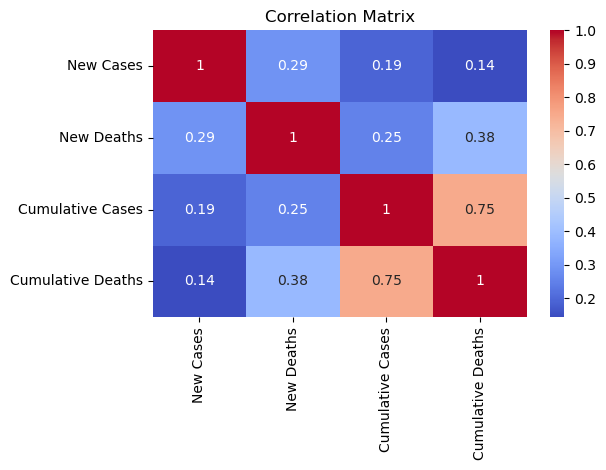

In [11]:
# Correlation Analysis
correlation = complete_dataset_cleaned[['New Cases', 'New Deaths', 'Cumulative Cases', 'Cumulative Deaths']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('COVID-19-ETL-Outputs/correlation_matrix.png', dpi=300)
plt.show()

### Global Statistics & Analysis
- Aggregating and analyzing global maximum and minimum cases and deaths.

The analysis reveals that the country with the highest number of cases and deaths was the United States of America, demonstrating the severe impact of the pandemic in that region. Conversely, the country with the fewest COVID-19 cases was Montserrat, while Nauru recorded the lowest number of deaths globally.


In [12]:
# Use aggregation to find the max, min cases and deaths all over the world
country_stats = complete_dataset_cleaned.groupby('Country').agg({
    'Cumulative Cases': 'max',
    'Cumulative Deaths': 'max'
}).reset_index()

# Find the country with maximum cases
max_cases_country = country_stats.loc[country_stats['Cumulative Cases'].idxmax()]

# Find the country with minimum cases
min_cases_country = country_stats.loc[country_stats['Cumulative Cases'].idxmin()]

# Find the country with maximum deaths
max_deaths_country = country_stats.loc[country_stats['Cumulative Deaths'].idxmax()]

# Find the country with minimum deaths
min_deaths_country = country_stats.loc[country_stats['Cumulative Deaths'].idxmin()]

# Display Results
print("Country with Maximum Cases:", max_cases_country)
print("\nCountry with Minimum Cases:", min_cases_country)
print("\nCountry with Maximum Deaths:", max_deaths_country)
print("\nCountry with Minimum Deaths:", min_deaths_country)

# Save the results to a text file using PyArrow
with pa.BufferOutputStream() as buffer:
    buffer.write(f"Country with Maximum Cases: {max_cases_country}\n".encode())
    buffer.write(f"\nCountry with Minimum Cases: {min_cases_country}\n".encode())
    buffer.write(f"\nCountry with Maximum Deaths: {max_deaths_country}\n".encode())
    buffer.write(f"\nCountry with Minimum Deaths: {min_deaths_country}\n".encode())
    result = buffer.getvalue()

with open('COVID-19-ETL-Outputs/Global_statistics.txt', 'wb') as file:
    file.write(result)

Country with Maximum Cases: Country              United States of America
Cumulative Cases                  103436829.0
Cumulative Deaths                   1127152.0
Name: 196, dtype: object

Country with Minimum Cases: Country              Montserrat
Cumulative Cases         1003.0
Cumulative Deaths           8.0
Name: 124, dtype: object

Country with Maximum Deaths: Country              United States of America
Cumulative Cases                  103436829.0
Cumulative Deaths                   1127152.0
Name: 196, dtype: object

Country with Minimum Deaths: Country               Nauru
Cumulative Cases     3970.0
Cumulative Deaths       1.0
Name: 128, dtype: object


### Local Statistics (Australian Data Analysis)
- Filtering Australian Data
- Calculating Key Metrics
- Summarize Data With Pivot Table

A focused analysis on Australia showcases the country’s pandemic trends. The findings highlight the total average new cases and identify the peak daily cases and deaths in Australia, providing a clear understanding of the pandemic’s progression in the region.

### Filtering Australian Data
Filter the data to Australia for analysis

In [13]:
# Filter by country Australia
australia_data = complete_dataset_cleaned[complete_dataset_cleaned['Country'] == 'Australia']
australia_data.head()

,id,Date,Country Code,Country,Continent,WHO Region,New Cases,Cumulative Cases,New Deaths,Cumulative Deaths,Coordinates,Case ID
2693,2694,2020-03-08,AU,Australia,Oceania,WPRO,45.0,70.0,4.0,4.0,"(-25.274398, 133.775136)",AU2694
2694,2695,2020-03-15,AU,Australia,Oceania,WPRO,179.0,249.0,3.0,7.0,"(-25.274398, 133.775136)",AU2695
2695,2696,2020-03-22,AU,Australia,Oceania,WPRO,832.0,1081.0,2.0,9.0,"(-25.274398, 133.775136)",AU2696
2696,2697,2020-03-29,AU,Australia,Oceania,WPRO,2728.0,3809.0,7.0,16.0,"(-25.274398, 133.775136)",AU2697
2697,2698,2020-04-05,AU,Australia,Oceania,WPRO,1826.0,5635.0,20.0,36.0,"(-25.274398, 133.775136)",AU2698


### Calculate Key Metrics for Australia
Finding the average new cases, maximum and minimum cases, and deaths.

In [14]:
# Calculate the average new cases in total in Australia
average_cases = australia_data['New Cases'].mean()
print(f"Average COVID-19 cases in Australia: {average_cases:.2f}")

# Find the day with maximum cases
max_cases_day = australia_data.loc[australia_data['New Cases'].idxmax()]
print(f"Maximum cases: {max_cases_day['New Cases']} on {max_cases_day['Date'].date()}")

# Find the day with minimum cases
min_cases_day = australia_data.loc[australia_data['New Cases'].idxmin()]
print(f"Minimum cases: {min_cases_day['New Cases']} on {min_cases_day['Date'].date()}")

# Find the day with maximum deaths
max_deaths_day = australia_data.loc[australia_data['New Deaths'].idxmax()]
print(f"Maximum deaths: {max_deaths_day['New Deaths']} on {max_deaths_day['Date'].date()}")

# Find the day with minimum deaths
min_deaths_day = australia_data.loc[australia_data['New Deaths'].idxmin()]
print(f"Minimum deaths: {min_deaths_day['New Deaths']} on {min_deaths_day['Date'].date()}")

Average COVID-19 cases in Australia: 64275.34
Maximum cases: 588813.0 on 2022-01-09
Minimum cases: 28.0 on 2021-02-21
Maximum deaths: 1161.0 on 2023-02-05
Minimum deaths: -76.0 on 2023-07-23


### Save Local Statistics for Australia
Using PyArrow to save Australian statistics to a text file.

In [15]:
# Save the result to a text file using PyArrow
with pa.BufferOutputStream() as buffer:
    buffer.write(f"Average COVID-19 cases in Australia: {average_cases:.2f}\n".encode())
    buffer.write(f"\nMaximum cases in Australia: {max_cases_day['New Cases']} on {max_cases_day['Date'].date()}\n".encode())
    buffer.write(f"\nMinimum cases in Australia: {min_cases_day['New Cases']} on {min_cases_day['Date'].date()}\n".encode())
    buffer.write(f"\nMaximum deaths in Australia: {max_deaths_day['New Deaths']} on {max_deaths_day['Date'].date()}\n".encode())
    buffer.write(f"\nMinimum deaths in Australia: {min_deaths_day['New Deaths']} on {min_deaths_day['Date'].date()}\n".encode())
    result = buffer.getvalue()

with open('COVID-19-ETL-Outputs/Australian_statistics.txt', 'wb') as file:
    file.write(result)

### Pivot Table Summary
Summarizing Australian data with a pivot table.

In [16]:
# Using pivot_table() to summarize the data
pivot_summary = australia_data.pivot_table(
    index='Date', values=['New Cases', 'New Deaths'], aggfunc='sum'
)

# Convert the summarized values to integers
pivot_summary = pivot_summary.astype(int)

# Display the pivot summary
pivot_summary

# Export the Detailed Covid Analysis
pivot_summary.to_csv('COVID-19-ETL-Outputs/Pivot_summary.csv', index=True)

### Visualize Pivot Table Summary
Creating a line plot to visualize new cases and deaths over time in Australia.

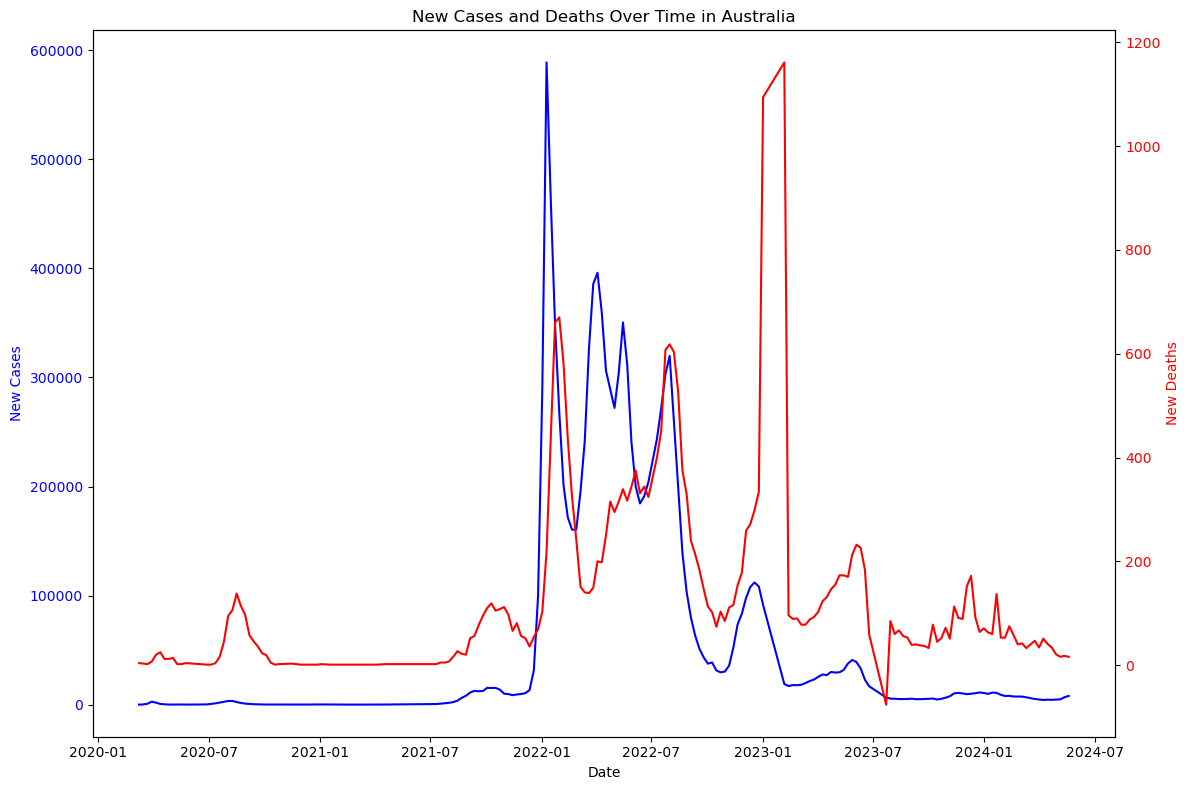

In [17]:
# Plotting pivot table summary with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting new cases on the primary y-axis
ax1.plot(pivot_summary.index, pivot_summary['New Cases'], label='New Cases', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('New Cases', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Creating a secondary y-axis for new deaths
ax2 = ax1.twinx()
ax2.plot(pivot_summary.index, pivot_summary['New Deaths'], label='New Deaths', color='r')
ax2.set_ylabel('New Deaths', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Enhancing the plot
plt.title('New Cases and Deaths Over Time in Australia')
fig.tight_layout()

# Save the plot as an image
plt.savefig('COVID-19-ETL-Outputs/Pivot_Summary_Plot.png', dpi=300)
plt.show()